In [1]:
# Name: Anay Abhijit Joshi
# Homework 3 - Medical Image Segmentation

In [2]:
# Here are the necessary Python libraries and modules
import os
import zipfile
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, concatenate

In [3]:
# Here is the name of the ZIP file that we want to extract
zip_filename = "Data.zip"

# Now, do the extraction. To be safe, we first check if the file is a valid ZIP archive, using a conditional loop.
if zipfile.is_zipfile(zip_filename):
    # If the file is a valid ZIP archive, we can proceed with the extraction.
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        # Extract all the contents of the ZIP file into a new directory called
        zip_ref.extractall("data")
    # Print a message to indicate that the extraction was successful.
    print("Extraction completed successfully.")
# If the file is not a valid ZIP archive, print an error message.
else:
    # Print an error message if the file is not a valid ZIP archive.
    print("Error: The file is not a valid ZIP archive.")

Extraction completed successfully.


In [4]:
# Again, the ZIP file
zip_filename = "Data.zip"

# The folder where the data will be extracted
extract_path = "data"

# Extract the data from the ZIP file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# The extracted data is structured as follows:
train_folder = os.path.join(extract_path, 'train')
test_folder = os.path.join(extract_path, 'test')

# Display the folder structure via the print statements
print(f"Success! Extraction completed.\n")
print(f"Directories are structured as follows:")
print(f"Train folder: {train_folder}")
print(f"Test folder: {test_folder}")

Success! Extraction completed.

Directories are structured as follows:
Train folder: data/train
Test folder: data/test


In [5]:
# Extraction path: data/Data
extract_path = "data/Data"

# Now, let's resize the images and masks to a common size.
def resize_image(image, new_size):
    image = image.resize(new_size, Image.ANTIALIAS)
    return image

# Define the new size for the images and masks.
new_image_size = (256, 256)

# Load and preprocess the data.
def load_and_prepare_retina_data(data_type="train"):
    images = []
    masks = []

    # Define the paths for the images and masks.
    image_path = os.path.join(extract_path, data_type, "image")
    # Define the path for the masks.
    mask_path = os.path.join(extract_path, data_type, "mask")

    # Check if the paths exist.
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        raise FileNotFoundError(f"One or both paths do not exist:\nImages: {image_path}\nMasks: {mask_path}")
    # Iterate over the files in the image path using "for" loop.
    for filename in sorted(os.listdir(image_path)):
        if not filename.endswith('.png'):
            continue
        # Read the image file.
        img = tf.io.read_file(os.path.join(image_path, filename))
        img = tf.image.decode_png(img, channels=1)
        # Resize the image.
        img = tf.image.resize(img, new_image_size)
        # Append the image to the images list.
        images.append(img)
        # Read the mask file.
        mask = tf.io.read_file(os.path.join(mask_path, filename))
        mask = tf.image.decode_png(mask, channels=1)
        # Resize the mask.
        mask = tf.image.resize(mask, new_image_size)
        # Append the mask to the masks list.
        masks.append(mask)
    # Return the images and masks as a stack.
    return tf.stack(images), tf.stack(masks)

# Load and preprocess the data for training and testing.
train_images, train_masks = load_and_prepare_retina_data(data_type="train")
test_images, test_masks = load_and_prepare_retina_data(data_type="test")

# Here, I will normalize the images and masks.
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.cast(test_images, tf.float32) / 255.0
train_masks = tf.cast(train_masks, tf.float32) / 255.0
test_masks = tf.cast(test_masks, tf.float32) / 255.0

# Print if successful.
print("Success! Data loaded and preprocessed.")

Success! Data loaded and preprocessed.


In [6]:
# Here is the IoU and Dice Coefficient functions and the data augmentation generator
# First, IoU function calculates the Intersection over Union metric
def IoU(
        y_true,
        y_pred,
        smooth=1):
    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    iou = (intersection + smooth) / (union - intersection + smooth)
    # Return the mean of the Intersection over Union values
    return tf.reduce_mean(iou)

# Next, Dice Coefficient function calculates the Dice Coefficient metric
def DiceCoefficient(
        y_true,
        y_pred,
        smooth=1):
    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    dice = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) + smooth)
    # Return the mean of the Dice Coefficient values
    return tf.reduce_mean(dice)

# Finally, the data augmentation generator is defined for the model to use and train on
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
# Let's create a generic U-Net model with a variable number of layers for U-Net architecture(s).
# The model will have have a configurable number of layers, and will be compiled with the Adam optimizer,
# binary crossentropy loss, and DiceCoefficient and IoU metrics.
def retina_unet_model(num_layers, input_shape = (None, None, 1)):
    # Define the input layer with the shape of the input image
    inputs = Input(input_shape)
    # Let's define a list to store the output of each layer
    x = inputs
    # Let's define a list to store the output of each down layer, initialized as an empty list, initially
    down_layers = []
    # Let's iterate over the number of layers using the range function
    for i in range(num_layers):
        # First Convolutional Layer
        # Define the convolutional layer with 64 * (2**i) filters, a kernel size of (3, 3), ReLU activation function, and same padding
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        # Define the batch normalization layer
        x = BatchNormalization()(x)
        # Second Convolutional Layer
        # Again, define the convolutional layer with 64 * (2**i) filters, a kernel size of (3, 3), ReLU activation function, and same padding
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        # Define the batch normalization layer
        x = BatchNormalization()(x)
        # If the current layer is not the last layer, apply dropout with a rate of 0.5
        if i < num_layers - 1:
            x = Dropout(0.5)(x)
        down_layers.append(x)
        # Define the max pooling layer with a pool size of (2, 2) and same padding
        x = MaxPooling2D((2, 2), padding='same')(x)

    # Define the bottleneck layer
    x = Dropout(0.5)(x)

    # Let's iterate over the number of layers in reverse order using the range function again
    for i in range(num_layers - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, down_layers[i]])
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64 * (2**i), (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
    # Define the output layer with a single filter, a kernel size of (1, 1), and a sigmoid activation function
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    # Return the model with the input and output layers
    return Model(inputs=inputs, outputs=outputs)

In [8]:
# Here, "test_model" function, as per the given requirements.
def test_model(*, model_name: str):
  """
  Test a U-Net model with a specified number of layers and evaluate its performance.

  -----------
  Function Parameters:
  -----------
  model_name : str
      The name of the model to train and evaluate. Please choose the model name:
      - 'UNet2': U-Net model with 2 layers.
      - 'UNet3': U-Net model with 3 layers.
      - 'UNet4': U-Net model with 4 layers.

  -----------

  Note:
  -----
  This function uses keyword-only arguments, and the `model_name` parameter is required.
  """

  # Here, I have considered the following model names: 'UNet2', 'UNet3', 'UNet4' for U-Net models with 2, 3, and 4 layers, respectively.

  # ################################################# U-Net 2 layers #######################################################
  if model_name == "UNet2":
    # Train and evaluate U-Net model with 2 layers of U-Net, call the function defined above
    model_2 = retina_unet_model(num_layers=2)
    # Compile the model
    model_2.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[DiceCoefficient, IoU])
    # Fit the model
    history = model_2.fit(train_images, train_masks, batch_size=4, epochs=75, validation_split=0.1)
    # Predict on test images for evaluation
    predicted_masks_2 = model_2.predict(test_images)
    # Save the predicted masks for future use (Step 6)
    np.save('predicted_masks_2.npy', predicted_masks_2)
    # Calculate Dice and IoU scores
    dice_score_2 = DiceCoefficient(test_masks, predicted_masks_2)
    # Calculate IoU score
    iou_score_2 = IoU(test_masks, predicted_masks_2)
    # Let's print the scores of Dice and IoU
    print(f" ")
    print(f" ")
    print(f"                           U-Net 2 Layers -> Dice Score: {dice_score_2.numpy()}")
    print(f"                           U-Net 2 Layers -> IoU Score: {iou_score_2.numpy()}")
    # Timestamp
    timestamp = datetime.now()
    print(f" ")
    print(f" ")
    print("                           Timestamp:", timestamp)
    print(f" ")

    # Plotting the training history
    plt.figure(figsize=(8, 11))

    # Dice Coefficient plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['dice_coefficient'], color="red", linestyle="--", linewidth=2, label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], color="blue", linestyle=":", linewidth=2, label='Validation Dice Coefficient')

    # Plot's Labels
    plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
    plt.ylabel('Dice Coefficient', fontsize=11, color="navy", fontweight="bold")
    plt.title('Training vs Validation Dice Coefficient', fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid
    plt.grid(True, linestyle="--", alpha=0.5)

    # Plot's Background Color
    plt.gca().set_facecolor("#FFF700")

    # IoU plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['io_u'], color="red", linestyle="--", linewidth=2, label='Train IoU')
    plt.plot(history.history['val_io_u'], color="blue", linestyle=":", linewidth=2, label='Validation IoU')

    # Plot's Labels
    plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
    plt.ylabel('IoU', fontsize=11, color="navy", fontweight="bold")
    plt.title('Training vs Validation IoU', fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid
    plt.grid(True, linestyle="--", alpha=0.5)

    # Plot's Background Color
    plt.gca().set_facecolor("#FFF700")

    plt.subplots_adjust(hspace=0.5)

    plt.tight_layout()
    plt.show()

  # ################################################# U-Net 3 layers #######################################################
  # Now, it's time for U-Net models with 3 layers
  elif model_name == "UNet3":
    # Train and evaluate U-Net model with 3 layers, call the function defined above
    model_3 = retina_unet_model(num_layers=3)
    # Compile the model
    model_3.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[DiceCoefficient, IoU])
    # Fit the model
    history = model_3.fit(train_images, train_masks, batch_size=4, epochs=75, validation_split=0.1)
    # Predict on test images for evaluation
    predicted_masks_3 = model_3.predict(test_images)
    # Save the predicted masks for future use (Step 6)
    np.save('predicted_masks_3.npy', predicted_masks_3)
    # Calculate Dice and IoU scores
    dice_score_3 = DiceCoefficient(test_masks, predicted_masks_3)
    # Calculate IoU score
    iou_score_3 = IoU(test_masks, predicted_masks_3)

    # Let's print the scores of Dice and IoU
    print(f" ")
    print(f" ")
    print(f"                           U-Net 3 Layers -> Dice Score: {dice_score_3.numpy()}")
    print(f"                           U-Net 3 Layers -> IoU Score: {iou_score_3.numpy()}")
    # Timestamp
    timestamp = datetime.now()
    print(f" ")
    print(f" ")
    print("                           Timestamp:", timestamp)
    print(f" ")

    # Plotting the training history
    plt.figure(figsize=(8, 11))

    # Dice Coefficient plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['dice_coefficient'], color="red", linestyle="--", linewidth=2, label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], color="blue", linestyle=":", linewidth=2, label='Validation Dice Coefficient')

    # Plot's Labels
    plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
    plt.ylabel('Dice Coefficient', fontsize=11, color="navy", fontweight="bold")
    plt.title('Training vs Validation Dice Coefficient', fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid
    plt.grid(True, linestyle="--", alpha=0.5)

    # Plot's Background Color
    plt.gca().set_facecolor("#FFF700")

    # IoU plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['io_u'], color="red", linestyle="--", linewidth=2, label='Train IoU')
    plt.plot(history.history['val_io_u'], color="blue", linestyle=":", linewidth=2, label='Validation IoU')

    # Plot's Labels
    plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
    plt.ylabel('IoU', fontsize=11, color="navy", fontweight="bold")
    plt.title('Training vs Validation IoU', fontsize=15, color="black", fontweight="bold")

    # Plot's Legend
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

    # Plot's Grid
    plt.grid(True, linestyle="--", alpha=0.5)

    # Plot's Background Color
    plt.gca().set_facecolor("#FFF700")

    plt.subplots_adjust(hspace=0.5)

    plt.tight_layout()
    plt.show()

  # ################################################# U-Net 4 layers (Extra) #######################################################
  elif model_name == "UNet4":
      # Train and evaluate U-Net model with 4 layers, call the function defined above
      model_4 = retina_unet_model(num_layers=4)
      # Compile the model
      model_4.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[DiceCoefficient, IoU])
      # Fit the model
      history = model_4.fit(train_images, train_masks, batch_size=4, epochs=75, validation_split=0.1)
      # Predict on test images for evaluation
      predicted_masks_4 = model_4.predict(test_images)
      # Save the predicted masks for future use (Step 6)
      np.save('predicted_masks_4.npy', predicted_masks_4)
      # Calculate Dice and IoU scores
      dice_score_4 = DiceCoefficient(test_masks, predicted_masks_4)
      # Calculate IoU score
      iou_score_4 = IoU(test_masks, predicted_masks_4)

      # Let's print the scores of Dice and IoU
      print(f" ")
      print(f" ")
      print(f"                           U-Net 4 Layers -> Dice Score: {dice_score_4.numpy()}")
      print(f"                           U-Net 4 Layers -> IoU Score: {iou_score_4.numpy()}")
      # Timestamp
      timestamp = datetime.now()
      print(f" ")
      print(f" ")
      print("                           Timestamp:", timestamp)
      print(f" ")

      # Plotting the training history
      plt.figure(figsize=(8, 11))

      # Dice Coefficient plot
      plt.subplot(2, 1, 1)
      plt.plot(history.history['dice_coefficient'], color="red", linestyle="--", linewidth=2, label='Train Dice Coefficient')
      plt.plot(history.history['val_dice_coefficient'], color="blue", linestyle=":", linewidth=2, label='Validation Dice Coefficient')

      # Plot's Labels
      plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
      plt.ylabel('Dice Coefficient', fontsize=11, color="navy", fontweight="bold")
      plt.title('Training vs Validation Dice Coefficient', fontsize=15, color="black", fontweight="bold")

      # Plot's Legend
      plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

      # Plot's Grid
      plt.grid(True, linestyle="--", alpha=0.5)

      # Plot's Background Color
      plt.gca().set_facecolor("#FFF700")

      # IoU plot
      plt.subplot(2, 1, 2)
      plt.plot(history.history['io_u'], color="red", linestyle="--", linewidth=2, label='Train IoU')
      plt.plot(history.history['val_io_u'], color="blue", linestyle=":", linewidth=2, label='Validation IoU')

      # Plot's Labels
      plt.xlabel('Epoch', fontsize=11, color="navy", fontweight="bold")
      plt.ylabel('IoU', fontsize=11, color="navy", fontweight="bold")
      plt.title('Training vs Validation IoU', fontsize=15, color="black", fontweight="bold")

      # Plot's Legend
      plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)

      # Plot's Grid
      plt.grid(True, linestyle="--", alpha=0.5)

      # Plot's Background Color
      plt.gca().set_facecolor("#FFF700")

      plt.subplots_adjust(hspace=0.5)

      plt.tight_layout()
      plt.show()
  # Finally, if the user enters an invalid model name, then the following message will be displayed to the user.
  else:
    print(f"Invalid Model Name! Please choose from 'UNet2', 'UNet3', or 'UNet4'.")

Epoch 1/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 464ms/step - dice_coefficient: 0.2322 - io_u: 0.1347 - loss: 0.7592 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.5492
Epoch 2/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - dice_coefficient: 0.5568 - io_u: 0.3906 - loss: 0.5046 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.3807
Epoch 3/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - dice_coefficient: 0.6876 - io_u: 0.5266 - loss: 0.3953 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.3429
Epoch 4/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - dice_coefficient: 0.7232 - io_u: 0.5683 - loss: 0.3305 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.2786
Epoch 5/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - dice_coefficient: 0.7305 - io_u: 0.5768 - loss: 0.2873 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.2809
Epoch 6/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - dice_coefficie

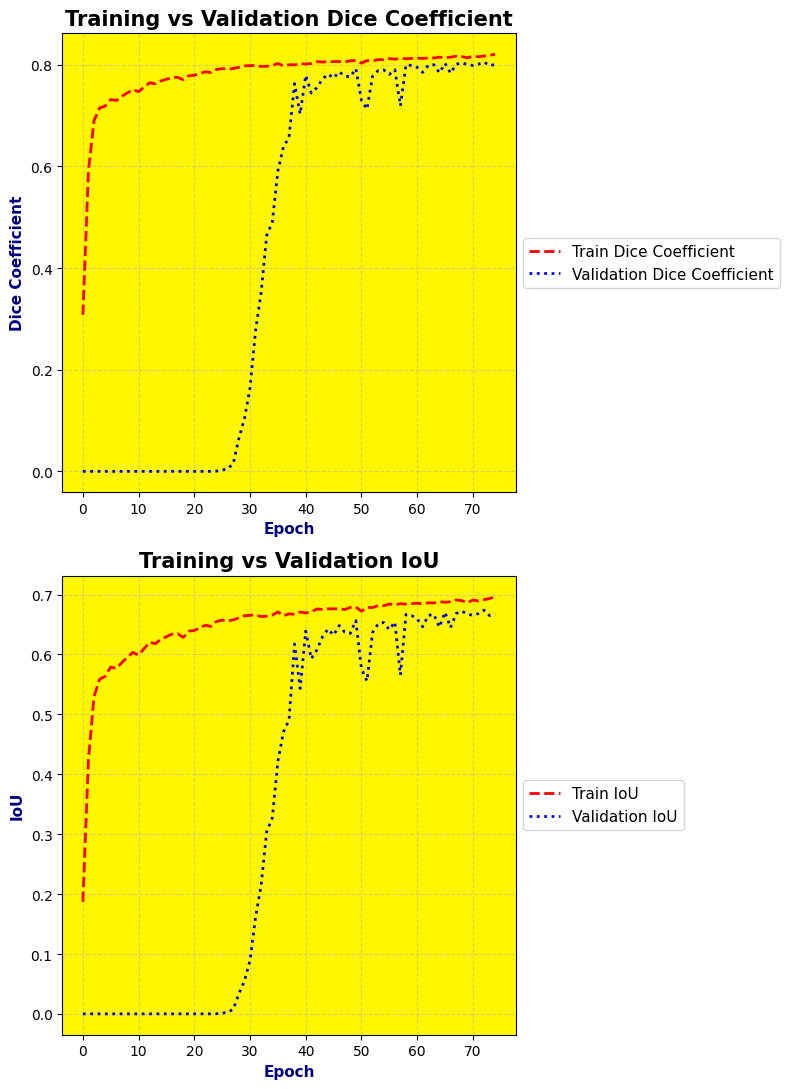

In [9]:
test_model(model_name="UNet2")

Epoch 1/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 530ms/step - dice_coefficient: 0.2103 - io_u: 0.1196 - loss: 0.7619 - val_dice_coefficient: 0.0025 - val_io_u: 0.0014 - val_loss: 0.2905
Epoch 2/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - dice_coefficient: 0.4772 - io_u: 0.3181 - loss: 0.5376 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.9393
Epoch 3/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - dice_coefficient: 0.6500 - io_u: 0.4852 - loss: 0.4361 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.5337
Epoch 4/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - dice_coefficient: 0.7067 - io_u: 0.5497 - loss: 0.3671 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.2850
Epoch 5/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - dice_coefficient: 0.7337 - io_u: 0.5817 - loss: 0.3087 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.3161
Epoch 6/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - dice_coefficient: 0.73

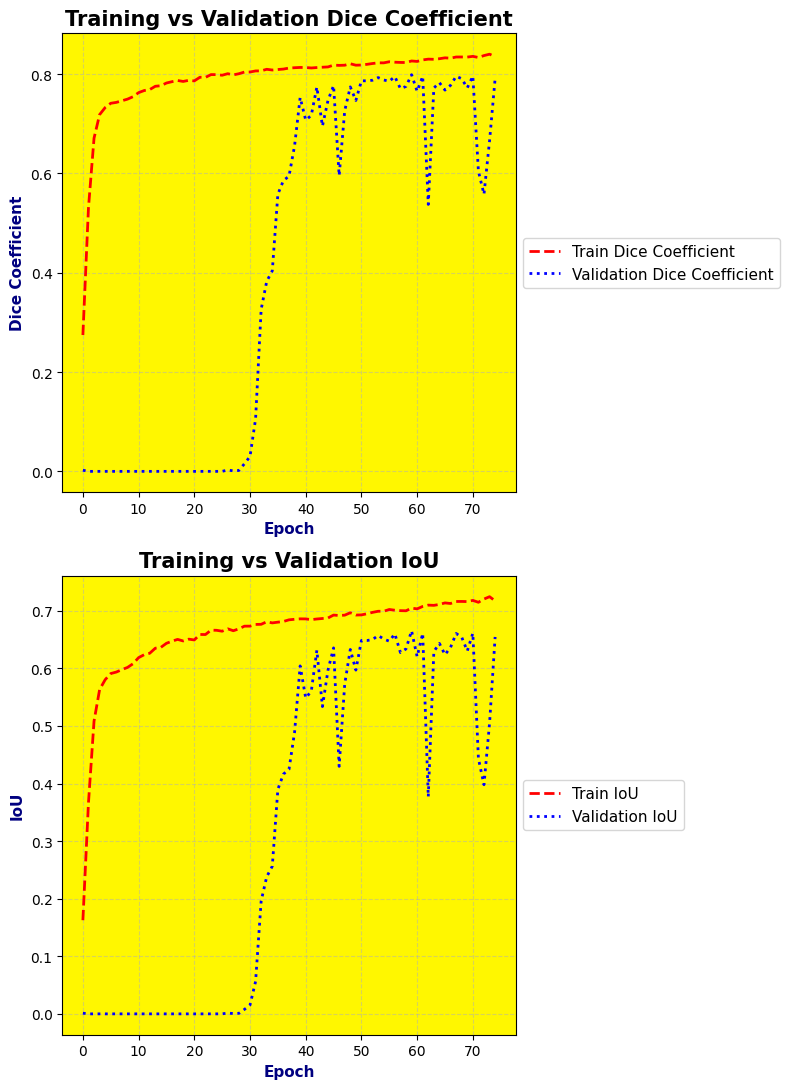

In [10]:
test_model(model_name="UNet3")

Epoch 1/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 579ms/step - dice_coefficient: 0.1859 - io_u: 0.1038 - loss: 0.8188 - val_dice_coefficient: 0.0104 - val_io_u: 0.0054 - val_loss: 1.3653
Epoch 2/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - dice_coefficient: 0.4111 - io_u: 0.2619 - loss: 0.5593 - val_dice_coefficient: 2.4921e-04 - val_io_u: 2.2712e-04 - val_loss: 8.6119
Epoch 3/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - dice_coefficient: 0.5843 - io_u: 0.4163 - loss: 0.4538 - val_dice_coefficient: 9.8308e-04 - val_io_u: 5.9033e-04 - val_loss: 1.3037
Epoch 4/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - dice_coefficient: 0.6742 - io_u: 0.5127 - loss: 0.3762 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.4213
Epoch 5/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - dice_coefficient: 0.7048 - io_u: 0.5460 - loss: 0.3207 - val_dice_coefficient: 2.0535e-04 - val_io_u: 2.0535e-04 - val_loss: 0.9933
Epoch 6/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - dice_coefficient: 0.715

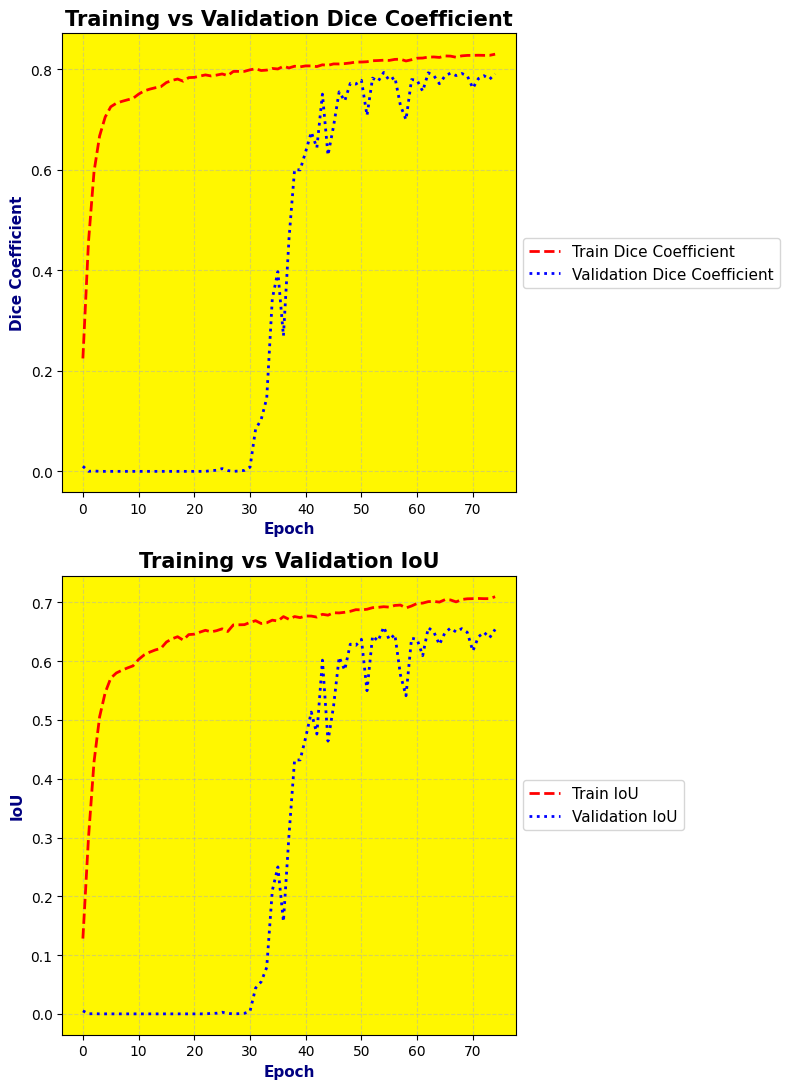

In [11]:
test_model(model_name="UNet4")

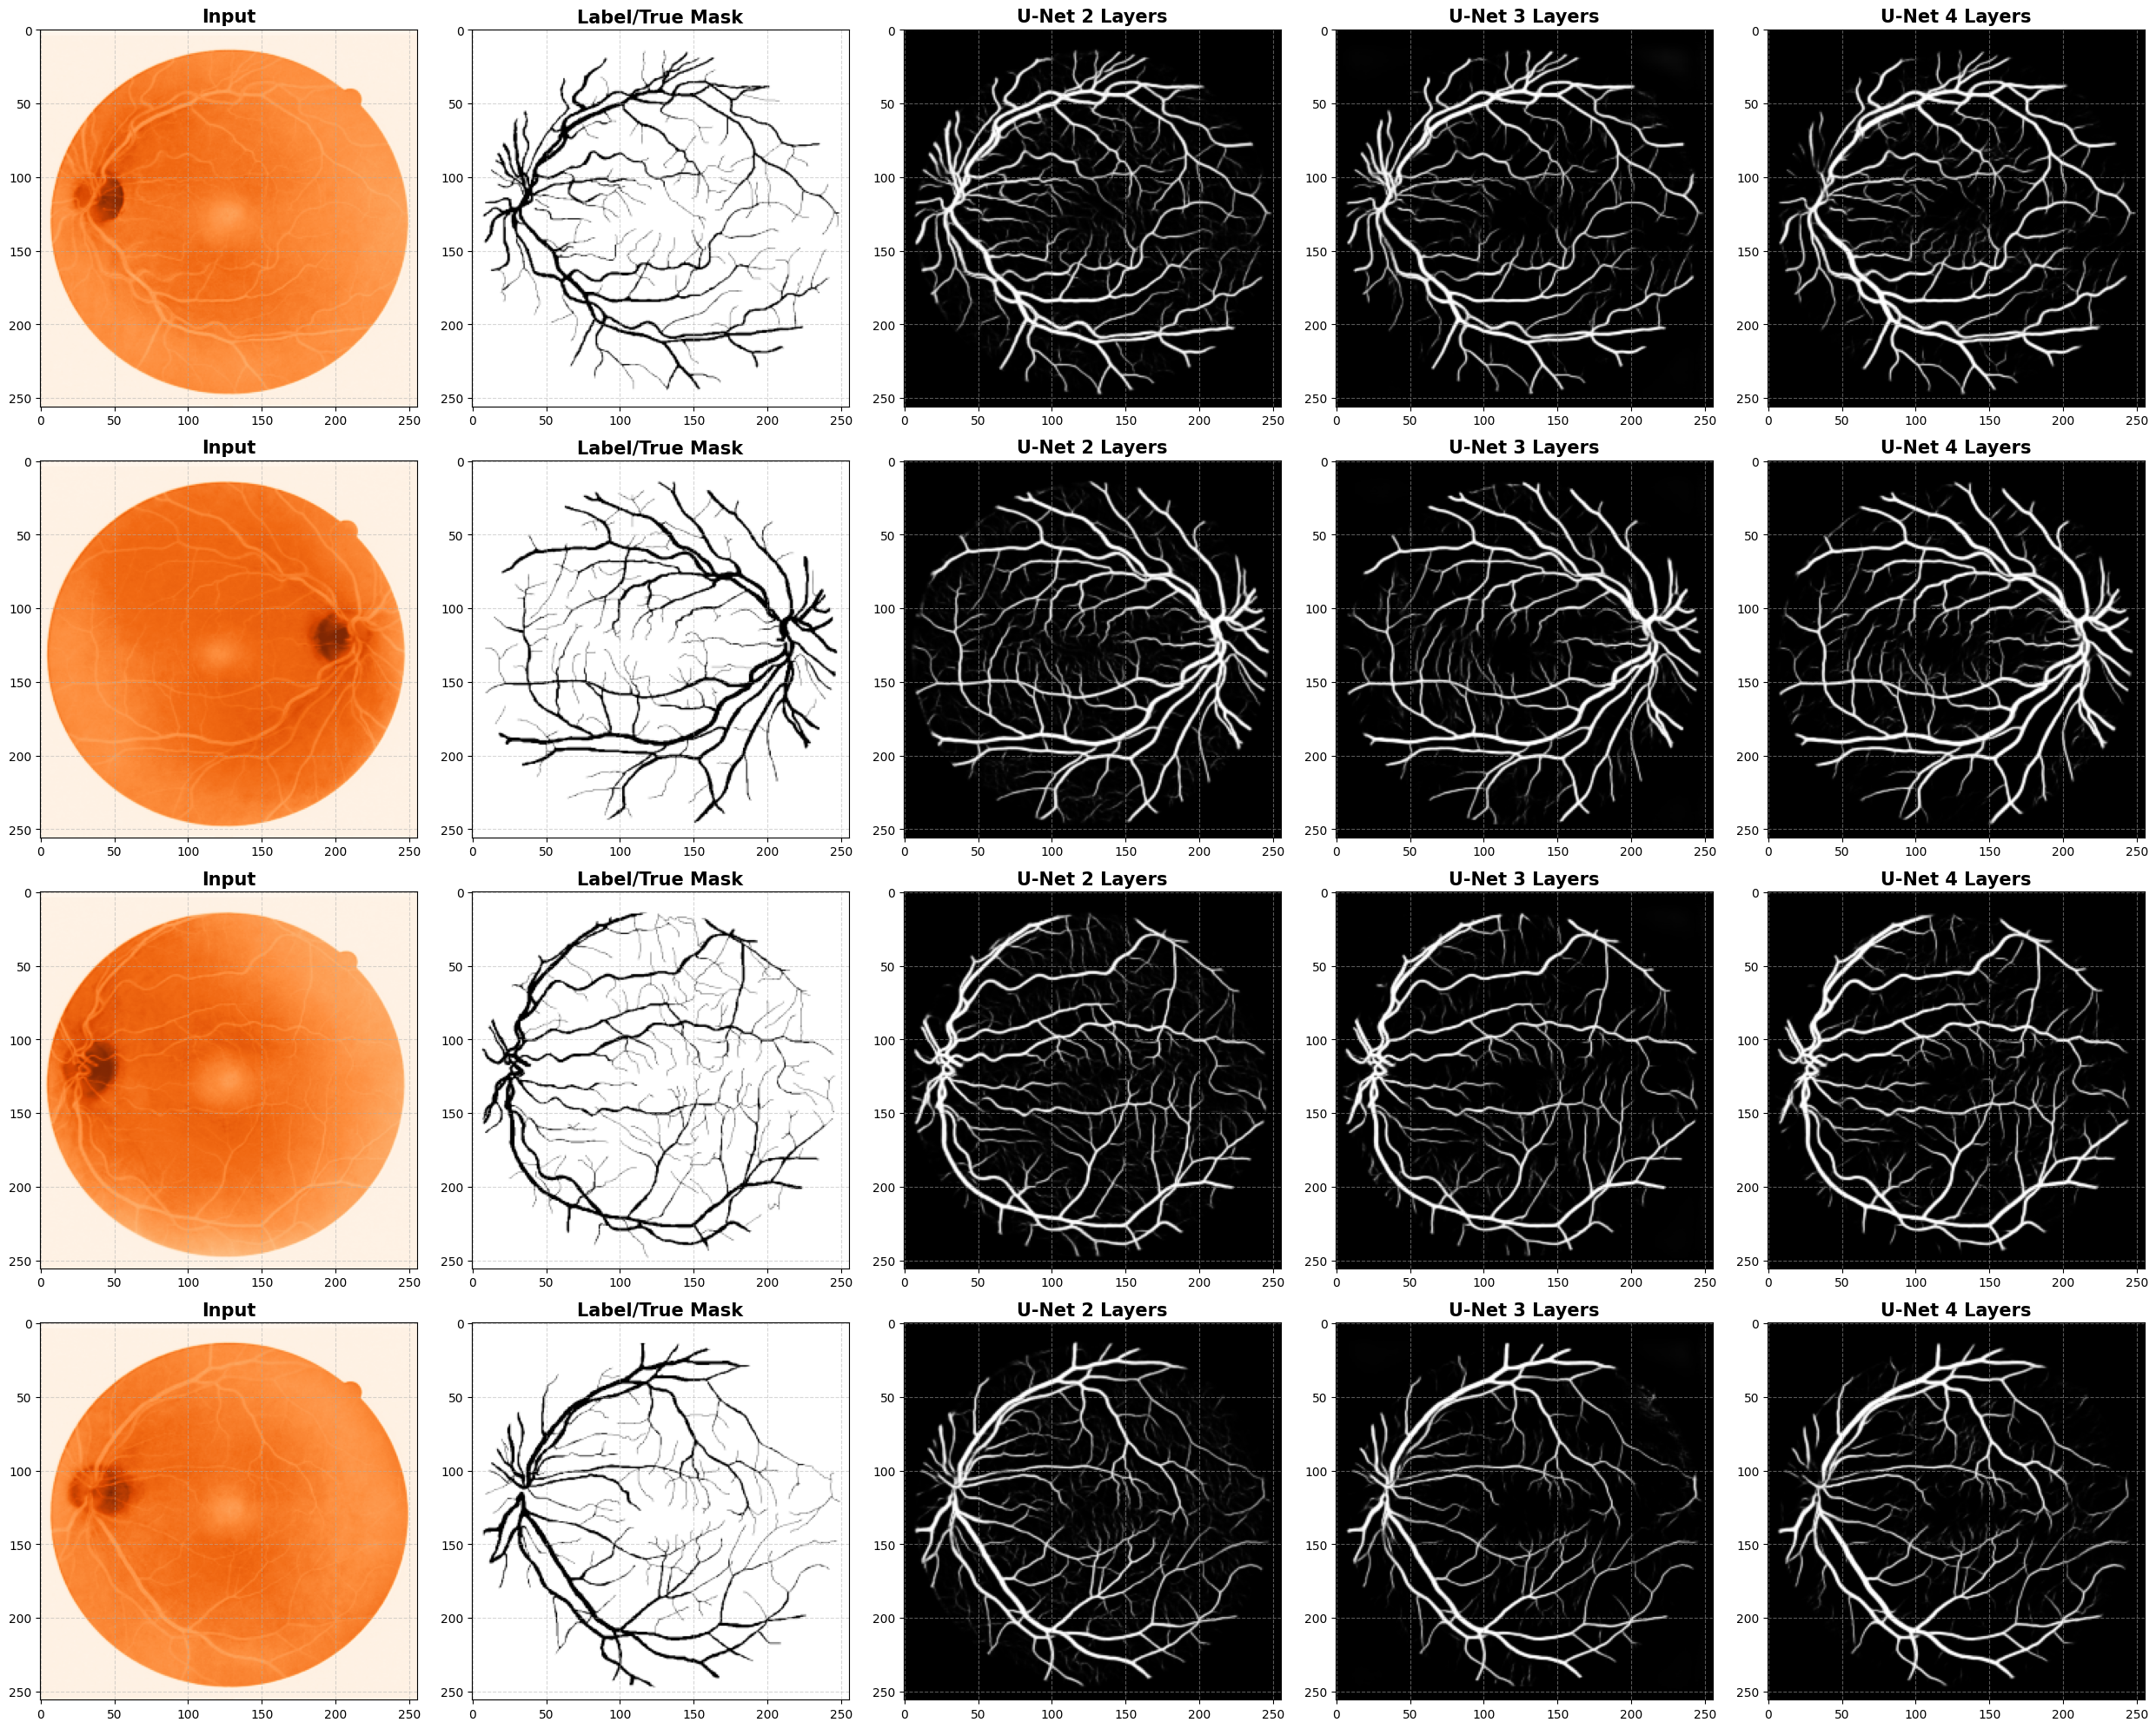

In [12]:
# Now, I don't want to run the entire code again, so I will load the predicted masks from the saved numpy files and plot them.
# Load the predicted masks for U-Net 2 Layers
predicted_masks_2 = np.load('predicted_masks_2.npy')
# Load the predicted masks for U-Net 3 Layers
predicted_masks_3 = np.load('predicted_masks_3.npy')
# Load the predicted masks for U-Net 4 Layers
predicted_masks_4 = np.load('predicted_masks_4.npy')

# Now, let's plot the images with their true masks and predicted masks
fig, ax = plt.subplots(4, 5, figsize=(25, 20))
# Loop through each image
for i in range(4):
    # Plot the images with their true masks and predicted masks
    # Input
    ax[i, 0].imshow(test_images[i, ..., 0], cmap="Oranges")         # Using a different colormap for better visualization and differentiation from U-Net 2, 3, 4 Layers and Label/True Mask
    # True mask or Label
    ax[i, 1].imshow(test_masks[i, ..., 0], cmap="Greys")            # Using a different colormap for better visualization and differentiation from U-Net 2, 3, 4 Layers and Input
    # Plot the predicted masks for U-Net 2, 3, and 4 layers
    # U-Net 2 Layers
    ax[i, 2].imshow(predicted_masks_2[i, ..., 0], cmap="gray")
    # U-Net 3 Layers
    ax[i, 3].imshow(predicted_masks_3[i, ..., 0], cmap="gray")
    # U-Net 4 Layers
    ax[i, 4].imshow(predicted_masks_4[i, ..., 0], cmap="gray")

    # Setting the titles for each subplot for better understanding
    ax[i, 0].set_title("Input", fontsize=15, color="black", fontweight="bold")
    ax[i, 1].set_title("Label/True Mask", fontsize=15, color="black", fontweight="bold")
    ax[i, 2].set_title("U-Net 2 Layers", fontsize=15, color="black", fontweight="bold")
    ax[i, 3].set_title("U-Net 3 Layers", fontsize=15, color="black", fontweight="bold")
    ax[i, 4].set_title("U-Net 4 Layers", fontsize=15, color="black", fontweight="bold")

    # Now, iterate over each subplot
    for j in range(5):
        ax[i, j].grid(True, linestyle="--", alpha=0.5)
        ax[i, j].set_facecolor("#FFF700")
# Display the plot
plt.tight_layout()
plt.show()